## Kickstarter Project Exploration

Explore cancer projects from Kickstarter

In [1]:
import os.path as op

import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = 100

from scipy.stats import ttest_ind

import statsmodels.api as sm

In [2]:
DATA_PROCESSED = '../data/processed'

In [3]:
data = pd.read_csv(op.join(DATA_PROCESSED, 'cancer_projects_full.csv'))

data.sample(5)

,id,name,blurb,created,launched,deadline,goal,spotlight,staff_pick,status,status_changed_at,backers,usd_pledged,pledged,currency,current_currency,category,geo_country,geo_state,geo_type,url,text,mean_donation,text_length_chars,text_length_words,text_length_sentences,pledged_to_goal,duration,month,day_of_week,year,from_US,from_Town,blurb_length_words
68,215789301,"Food fight against cancer, animal abuse and mu...",I'm a business owner & former chef. I have an ...,1510931812,1512181098,1517365098,25000,False,False,failed,1517365098,0,0.000000,0.00,USD,USD,food,US,NY,Town,https://www.kickstarter.com/projects/203003512...,First and foremost... Thank you for reading th...,0.000000,4429,828,42,0.000000,5184000,12,5,2017,1,1,24
5,798429667,Grumpy Fish Aid…Comfort Tips From Kids with Ca...,"Illustrated acupressure, reflexology points; s...",1398449643,1408055669,1410561000,10000,True,False,successful,1410561010,208,10901.000000,10901.00,USD,USD,publishing,US,NY,Town,https://www.kickstarter.com/projects/grumpyfis...,"Video production, editing, and post done by Me...",52.408654,3239,537,23,1.090100,2505331,8,3,2014,1,1,17
366,1692789349,The Eulogy of Toby Peach - Edinburgh Festival ...,"An honest & inspiring journey with cancer, dis...",1435588770,1436283107,1438875107,3000,True,False,successful,1438875107,90,4753.635632,3055.00,GBP,USD,theater,GB,Scotland,Town,https://www.kickstarter.com/projects/421295000...,Hello! Thanks so much for taking the time to v...,52.818174,7050,1231,40,1.018333,2592000,7,1,2015,0,1,19
75,871430700,Gone to Die in Dublin,"After Chris loses his wife to leukemia, he has...",1366855127,1367893980,1370485980,2500,True,False,successful,1370485983,25,2602.890000,2602.89,USD,USD,publishing,IE,Dublin,Town,https://www.kickstarter.com/projects/797894602...,The funds raised for this project will go dire...,104.115600,1718,329,24,1.041156,2592000,5,1,2013,0,1,23
66,359963115,UNTITLED BREAST CANCER PROJECT Based on true s...,Breast Cancer drama about a young woman diagno...,1498883984,1499922768,1502514768,5000,False,False,failed,1502514770,1,1.000000,1.00,USD,USD,film & video,US,GA,Town,https://www.kickstarter.com/projects/109677522...,"Carlette Edward, a 30-year-old Mother is diagn...",1.000000,777,143,7,0.000200,2592000,7,3,2017,1,1,19


In [4]:
data.shape

(455, 34)

Clean out projects not classified as Success or Fail

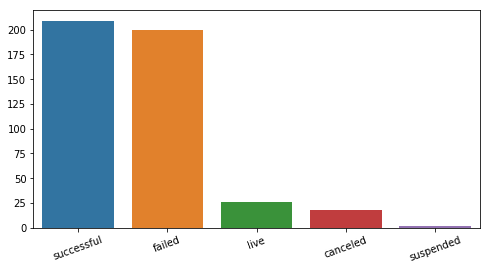

In [5]:
cnt = data['status'].value_counts()
plt.subplots(figsize=(8,4))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20);

In [6]:
data = data[data['status'].isin(['successful', 'failed'])]
data['status'] = data['status'].apply(lambda r: 1 if r == 'successful' else 0)
data.shape

(409, 34)

Popular Country of Origin

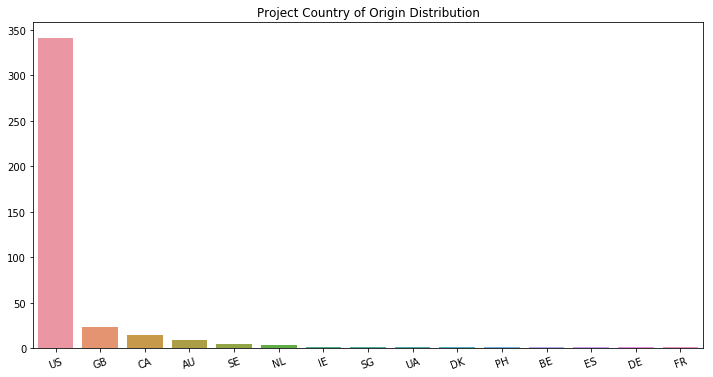

In [7]:
cnt = data['geo_country'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Country of Origin Distribution');

Popular Project Parent Categories

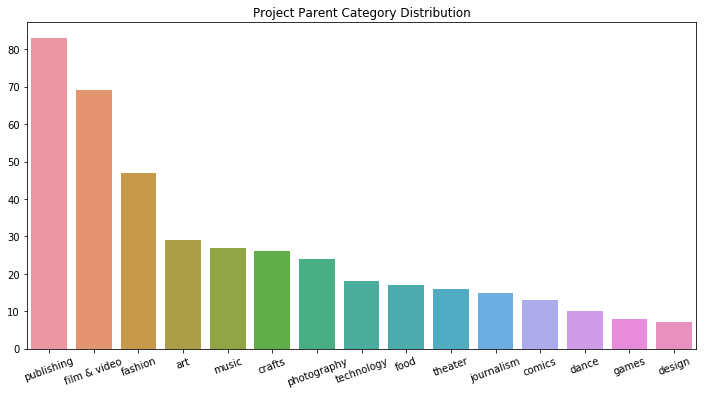

In [8]:
cnt = data['category'].value_counts()
plt.subplots(figsize=(12,6))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Parent Category Distribution');

Geo Types

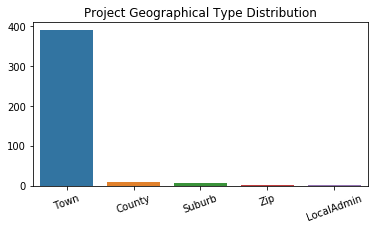

In [9]:
cnt = data['geo_type'].value_counts()
plt.subplots(figsize=(6,3))
sns.barplot(cnt.index, cnt.values)
plt.xticks(rotation=20)
plt.title('Project Geographical Type Distribution');

Duration

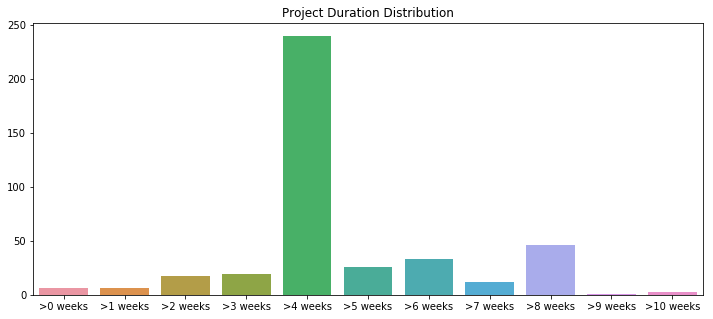

In [12]:
plt.subplots(figsize=(12,5))
td = pd.Series([ pd.Timedelta(days=i) for i in range(0, 92, 7)])
r = pd.cut(pd.TimedeltaIndex(data['duration'], unit='s').to_series(), td, labels=False).value_counts()
g = sns.barplot(r.index, r.values)
g.set_xticklabels([f'>{int(w)} weeks' for w in td.dt.days / 7])
plt.title('Project Duration Distribution');

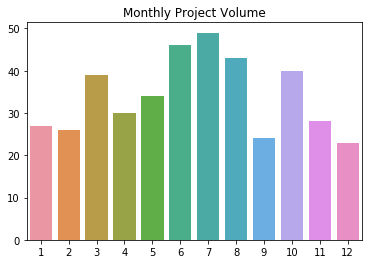

In [13]:
vc = data['month'].value_counts()
sns.barplot(vc.index, vc.values)
plt.title('Monthly Project Volume');